In [1]:
import math
import numpy as np
from scipy import linalg, fftpack
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
dir = ""

to cite:

the code:https://gist.github.com/agramfort/9875439

In [2]:
df_f1 = pd.read_csv(dir + "S040R01.csv")
df_f2 = pd.read_csv(dir + "S040R02.csv")

In [65]:
def cov(X, p):
    """vector autocovariance up to order p
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    Returns
    -------
    R : ndarray, shape (p + 1, N, N)
        The autocovariance up to order p
    """
    N, n = X.shape
    R = np.zeros((p + 1, N, N))
    for k in range(p + 1):
        R[k] = (1. / float(n - k)) * np.dot(X[:, :n - k], X[:, k:].T)
    return R

def mvar_fit(X, p):
    """Fit MVAR model of order p using Yule Walker
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    n_fft : int
        The length of the FFT
    Returns
    -------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N,)
        The noise for each time series
    """
    N, n = X.shape
    gamma = cov(X, p)  # gamma(r,i,j) cov between X_i(0) et X_j(r)
    G = np.zeros((p * N, p * N))
    gamma2 = np.concatenate(gamma, axis=0)
    gamma2[:N, :N] /= 2.

    for i in range(p):
        G[N * i:, N * i:N * (i + 1)] = gamma2[:N * (p - i)]

    G = G + G.T  # big block matrix

    gamma4 = np.concatenate(gamma[1:], axis=0)

    phi = linalg.solve(G, gamma4)  # solve Yule Walker

    tmp = np.dot(gamma4[:N * p].T, phi)
    sigma = gamma[0] - tmp - tmp.T + np.dot(phi.T, np.dot(G, phi))

    phi = np.reshape(phi, (p, N, N))
    for k in range(p):
        phi[k] = phi[k].T

    return phi, sigma


def compute_order(X, p_max):
    """Estimate AR order with BIC
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    p_max : int
        The maximum model order to test
    Returns
    -------
    p : int
        Estimated order
    bic : ndarray, shape (p_max + 1,)
        The BIC for the orders from 0 to p_max.
    """
    N, n = X.shape

    bic = np.empty(p_max + 1)
    bic[0] = np.inf # XXX

    Y = X.T

    for p in range(1, p_max + 1):
        print(p)
        A, sigma = mvar_fit(X, p)
        A_2d = np.concatenate(A, axis=1)

        n_samples = n - p
        bic[p] = n_samples * N * math.log(2. * math.pi)
        bic[p] += n_samples * np.log(linalg.det(sigma))
        bic[p] += p * (N ** 2) * math.log(n_samples)

        sigma_inv = linalg.inv(sigma)
        S = 0.
        for i in range(p, n):
            res = Y[i] - np.dot(A_2d, Y[i - p:i][::-1, :].ravel())
            S += np.dot(res, sigma_inv.dot(res))

        bic[p] += S

    p = np.argmin(bic)
    return p, bic


def spectral_density(A, n_fft=None):
    """Estimate PSD from AR coefficients
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    n_fft : int
        The length of the FFT
    Returns
    -------
    fA : ndarray, shape (n_fft, N, N)
        The estimated spectral density.
    """
    p, N, N = A.shape
    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)
    A2 = np.zeros((n_fft, N, N))
    A2[1:p + 1, :, :] = A  # start at 1 !
    fA = fftpack.fft(A2, axis=0)
    freqs = fftpack.fftfreq(n_fft)
    I = np.eye(N)

    for i in range(n_fft):
        fA[i] = linalg.inv(I - fA[i])

    return fA, freqs


def DTF(A, sigma=None, n_fft=None):
    """Direct Transfer Function (DTF)
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N, )
        The noise for each time series
    n_fft : int
        The length of the FFT
    Returns
    -------
    D : ndarray, shape (n_fft, N, N)
        The estimated DTF
    """
    p, N, N = A.shape

    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)

    H, freqs = spectral_density(A, n_fft)
    D = np.zeros((n_fft, N, N))

    if sigma is None:
        sigma = np.ones(N)

    for i in range(n_fft):
        S = H[i]
        V = (S * sigma[None, :]).dot(S.T.conj())
        V = np.abs(np.diag(V))
        D[i] = np.abs(S * np.sqrt(sigma[None, :])) / np.sqrt(V)[:, None]

    return D, freqs


def PDC(A, sigma=None, n_fft=None):
    """Partial directed coherence (PDC)
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N,)
        The noise for each time series.
    n_fft : int
        The length of the FFT.
    Returns
    -------
    P : ndarray, shape (n_fft, N, N)
        The estimated PDC.
    """
    p, N, N = A.shape

    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)

    H, freqs = spectral_density(A, n_fft)
    P = np.zeros((n_fft, N, N))

    if sigma is None:
        sigma = np.ones(N)

    for i in range(n_fft):
        B = H[i]
        B = linalg.inv(B)
        V = np.abs(np.dot(B.T.conj(), B * (1. / sigma[:, None])))
        V = np.diag(V)  # denominator squared
        P[i] = np.abs(B * (1. / np.sqrt(sigma))[None, :]) / np.sqrt(V)[None, :]

    return P, freqs
def edges(th,M):
    N = M.shape[0]
    edges = []
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                if M[i,j]>th:
                    A[i,j] = 1
                    edges.append((i,j))
    return(edges)

def graph(df,d,P = False,D = False,freq = None):
    th = np.arange(0,1,0.001)
    Y = np.array(df).T
    mu = np.mean(Y, axis=1)
    X = Y - mu[:, None]
    A_est, sigma = mvar_fit(X, p)
    sigma = np.diag(sigma)  # DTF + PDC support diagonal noise
    if P:
        M, freqs = PDC(A_est, sigma)
    else:
        M, freqs = DTF(A_est, sigma)
    if freq == None:
        f = int(np.argwhere(np.round(freqs*160) ==10)[0])
    else:
        f = int(np.argwhere(np.round(freqs*160) ==freq)[0])   
    nodes = np.arange(len(list(df.columns)))
    dens = 0
    for t in th:
        ed = edges(t,M[f,:,:])
        G=nx.DiGraph()
        G.add_edges_from(ed)
        G.add_nodes_from(nodes)
        dens = nx.density(G)
        if int(dens*100) == d:
            break
    return(G)


## Eyes open

1
2
3
4
5
6
7
8
9


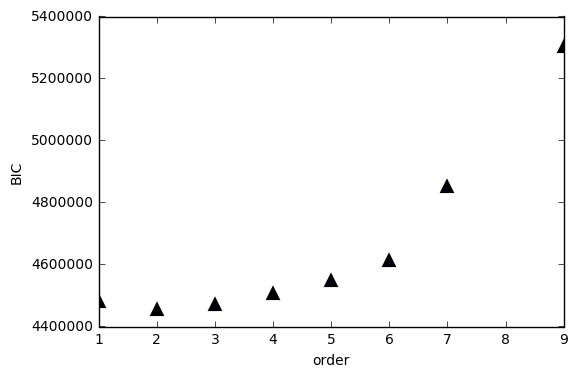

In [4]:
Y = np.array(df_f1).T
mu = np.mean(Y, axis=1)
X = Y - mu[:, None] #normalizing
#chosing model with BIC
p_max = 9#maximum lag
p, bic = compute_order(X, p_max=p_max)

plt.figure()
#plt.scatter(np.arange(p_max+1),bic,  s=50,marker='x',color='b',linewidths=2)
plt.plot(np.arange(p_max + 1), bic,'b^', markeredgewidth = 3)
plt.xlabel('order')
plt.ylabel('BIC')
#plt.title("BIC model selection (eyes open)")
plt.savefig( "BIC_eyes_open", bbox_inches='tight')
plt.show()

### PDC eyes open

In [5]:
A_est, sigma = mvar_fit(X, p)
sigma = np.diag(sigma)  # DTF + PDC support diagonal noise
# compute PDC
P_open, P_freqs = PDC(A_est, sigma)

In [6]:
f = int(np.argwhere(np.round(P_freqs*160) ==10)[0])

In [7]:
f

31

In [8]:
def edges(th,M):
    N = M.shape[0]
    edges = []
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                if M[i,j]>th:
                    A[i,j] = 1
                    edges.append((i,j))
    return(edges)


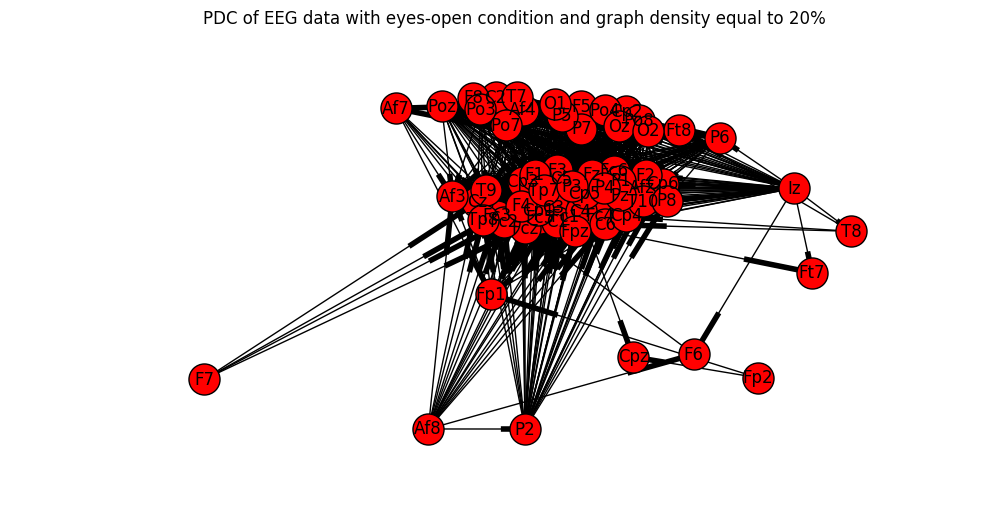

In [9]:
nodes = np.arange(len(list(df_f1.columns)))
labels = dict(zip(nodes, list(df_f1.columns)))
G_P_open=graph(df_f1,20,P = True)
plt.figure(figsize=(12,6))
plt.title("PDC of EEG data with eyes-open condition and graph density equal to 20%")
nx.draw(G_P_open, node_size=500, labels=labels, with_labels=True)
plt.savefig("PDC_eyes_open", bbox_inches='tight')
plt.show()

In [10]:
nx.density(G_P_open)

0.20858134920634921

### DFT eyes open

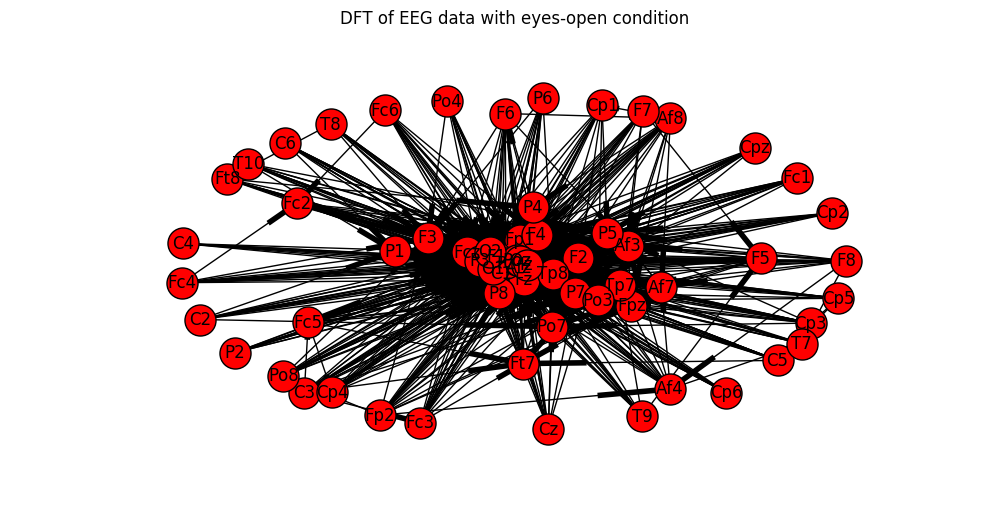

In [11]:
G_D_open=graph(df_f1,20,D = True)
plt.figure(figsize=(12,6))
plt.title("DFT of EEG data with eyes-open condition")
nx.draw(G_D_open, node_size=500, labels=labels, with_labels=True)
plt.savefig( "DFT_eyes_open", bbox_inches='tight')
plt.show()

In [12]:
nx.density(G_D_open)

0.20932539682539683

## Eyes closed

1
2
3
4
5
6
7
8
9
10


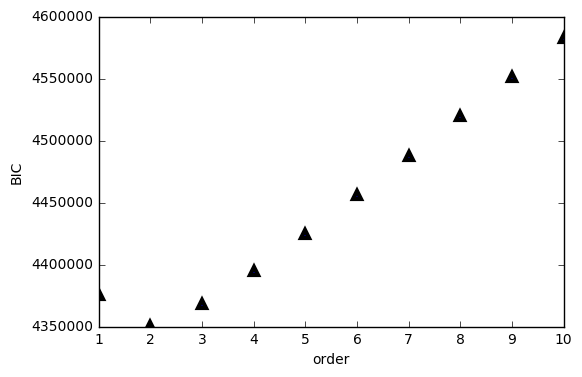

In [13]:
Y = np.array(df_f2).T
mu = np.mean(Y, axis=1)
X = Y - mu[:, None] #normalizing
#chosing model with BIC
p_max = 10 #maximum lag
p, bic = compute_order(X, p_max=p_max)

plt.figure()
plt.plot(np.arange(p_max + 1), bic,'b^', markeredgewidth = 3)
plt.xlabel('order')
plt.ylabel('BIC')
#plt.title("BIC model selection (eyes closed)")
plt.savefig( "BIC_eyes_closed", bbox_inches='tight')
plt.show()


### DFT eyes closed

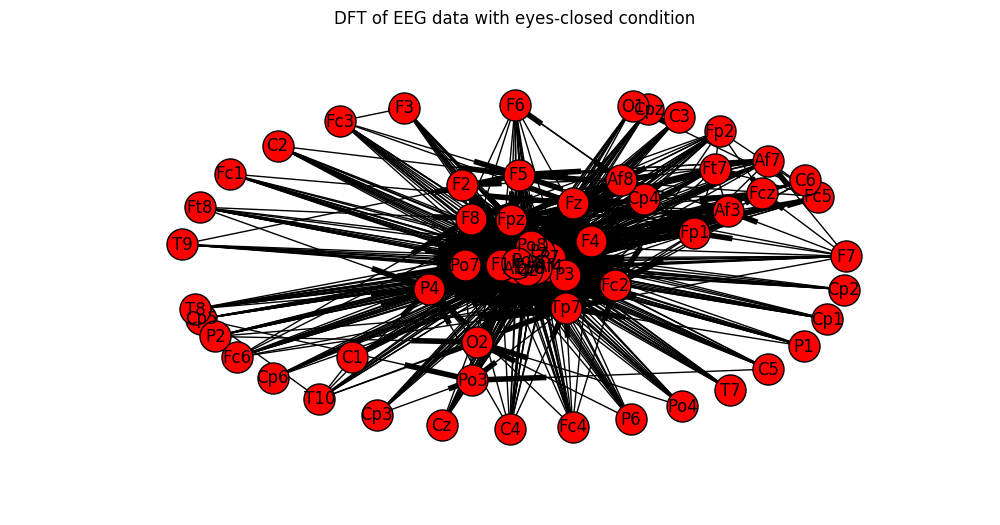

In [14]:
G_D_closed=graph(df_f2,20,D = True)
plt.figure(figsize=(12,6))
plt.title("DFT of EEG data with eyes-closed condition")
nx.draw(G_D_closed, node_size=500, labels=labels, with_labels=True)
plt.savefig( "DFT_eyes_closed", bbox_inches='tight')
plt.show()


In [15]:
nx.density(G_D_closed) #density is close enough to 20%

0.20734126984126985

### PDC eyes closed

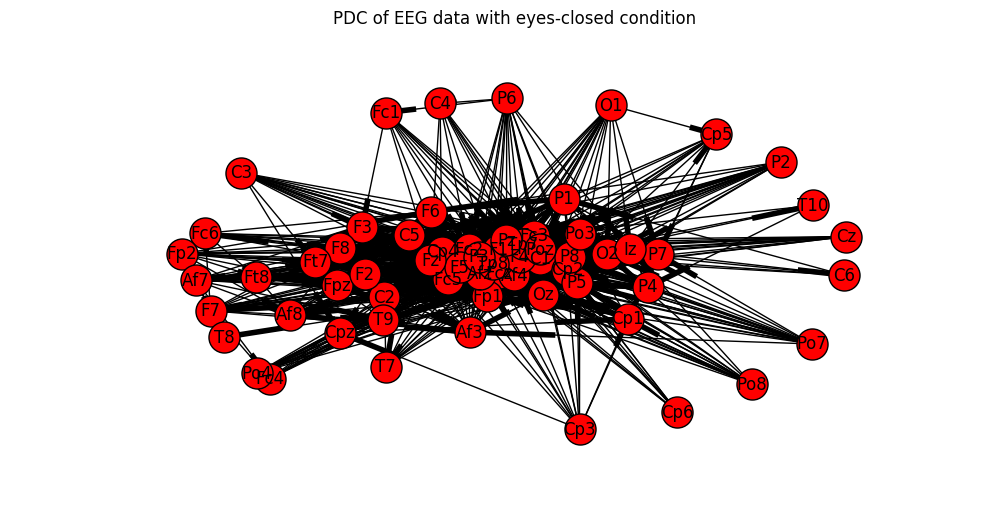

In [16]:
G_P_closed=graph(df_f2,20,P = True)
plt.figure(figsize=(12,6))
plt.title("PDC of EEG data with eyes-closed condition")
nx.draw(G_P_closed, node_size=500, labels=labels, with_labels=True)
plt.savefig("PDC_eyes_closed", bbox_inches='tight')
plt.show()

In [17]:
nx.density(G_P_closed)

0.2058531746031746

Now let;s save the graphs:

In [18]:
nx.write_weighted_edgelist(G_P_closed, path=dir + "G_P_closed.nx")
nx.write_weighted_edgelist(G_P_open, path=dir + "G_P_open.nx")
nx.write_weighted_edgelist(G_D_closed, path=dir + "G_D_closed.nx")
nx.write_weighted_edgelist(G_D_open, path=dir + "G_D_open.nx")

## Let's try 2.5

### Preprocessing

In [19]:
import re
locations = pd.read_csv("channel_locations.csv", sep = "\s+") 
locations["label"] = locations["label"].apply(lambda x:re.sub('[^\w]',"",x))
locations

﻿# label             x             y
0    1   Fc5 -2.781552e-01  1.123820e-01
1    2   Fc3 -1.896596e-01  1.095000e-01
2    3   Fc1 -9.367829e-02  1.040403e-01
3    4   Fcz  0.000000e+00  1.010000e-01
4    5   Fc2  9.367829e-02  1.040403e-01
5    6   Fc4  1.896596e-01  1.095000e-01
6    7   Fc6  2.781552e-01  1.123820e-01
7    8    C5 -3.040000e-01  1.862230e-17
8    9    C3 -2.030000e-01  1.243530e-17
9   10    C1 -1.010000e-01  6.187000e-18
10  11    Cz  0.000000e+00  0.000000e+00
11  12    C2  1.010000e-01  6.187000e-18
12  13    C4  2.030000e-01  1.243530e-17
13  14    C6  3.040000e-01  1.862230e-17
14  15   Cp5 -2.781552e-01 -1.123820e-01
15  16   Cp3 -1.896596e-01 -1.095000e-01
16  17   Cp1 -9.367829e-02 -1.040403e-01
17  18   Cpz  1.237400e-17 -1.010000e-01
18  19   Cp2  9.367829e-02 -1.040403e-01
19  20   Cp4  1.896596e-01 -1.095000e-01
20  21   Cp6  2.781552e-01 -1.123820e-01
21  22   Fp1 -1.254609e-01  3.861289e-01
22  23   Fpz  0.000000e+00  4.060000e-01
23  24   Fp2  1.254609e-01  3.861289e-01
24  25   Af7 -2.386408e-01  3.284609e-01
25  26   Af3 -1.340208e-01  3.157332e-01
26  27   Afz  0.000000e+00  3.040000e-01
27  28   Af4  1.340208e-01  3.157332e-01
28  29   Af8  2.386408e-01  3.284609e-01
29  30    F7 -3.284609e-01  2.386408e-01
..  ..   ...           ...           ...
34  35    F2  7.848258e-02  2.044541e-01
35  36    F4  1.577335e-01  2.252668e-01
36  37    F6  2.611203e-01  2.521610e-01
37  38    F8  3.284609e-01  2.386408e-01
38  39   Ft7 -3.861289e-01  1.254609e-01
39  40   Ft8  3.861289e-01  1.254609e-01
40  41    T7 -4.060000e-01  2.487050e-17
41  42    T8  4.060000e-01  2.487050e-17
42  43    T9 -4.990000e-01  3.056750e-17
43  44   T10  4.990000e-01  3.056750e-17
44  45   Tp7 -3.861289e-01 -1.254609e-01
45  46   Tp8  3.861289e-01 -1.254609e-01
46  47    P7 -3.284609e-01 -2.386408e-01
47  48    P5 -2.467336e-01 -2.382678e-01
48  49    P3 -1.577335e-01 -2.252668e-01
49  50    P1 -7.848258e-02 -2.044541e-01
50  51    Pz  2.217520e-17 -1.810000e-01
51  52    P2  7.848258e-02 -2.044541e-01
52  53    P4  1.577335e-01 -2.252668e-01
53  54    P6  2.467336e-01 -2.382678e-01
54  55    P8  3.284609e-01 -2.386408e-01
55  56   Po7 -2.386408e-01 -3.284609e-01
56  57   Po3 -1.340208e-01 -3.157332e-01
57  58   Poz  3.724450e-17 -3.040000e-01
58  59   Po4  1.340208e-01 -3.157332e-01
59  60   Po8  2.386408e-01 -3.284609e-01
60  61    O1 -1.254609e-01 -3.861289e-01
61  62    Oz  4.974100e-17 -4.060000e-01
62  63    O2  1.254609e-01 -3.861289e-01
63  64    Iz  6.113490e-17 -4.990000e-01

[64 rows x 4 columns]

In [20]:
reduced = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","O2"]

In [21]:
cond = (locations["label"] == reduced[0])
for i in range(1,len(reduced)):
    cond = cond | (locations["label"] == reduced[i])

In [22]:
locations = locations[cond]
locations = locations.set_index('label')
locations

﻿#             x             y
label                                
C3      9 -2.030000e-01  1.243530e-17
Cz     11  0.000000e+00  0.000000e+00
C4     13  2.030000e-01  1.243530e-17
Fp1    22 -1.254609e-01  3.861289e-01
Fp2    24  1.254609e-01  3.861289e-01
F7     30 -3.284609e-01  2.386408e-01
F3     32 -1.577335e-01  2.252668e-01
Fz     34  0.000000e+00  2.030000e-01
F4     36  1.577335e-01  2.252668e-01
F8     38  3.284609e-01  2.386408e-01
T7     41 -4.060000e-01  2.487050e-17
T8     42  4.060000e-01  2.487050e-17
P7     47 -3.284609e-01 -2.386408e-01
P3     49 -1.577335e-01 -2.252668e-01
Pz     51  2.217520e-17 -1.810000e-01
P4     53  1.577335e-01 -2.252668e-01
P8     55  3.284609e-01 -2.386408e-01
O1     61 -1.254609e-01 -3.861289e-01
O2     63  1.254609e-01 -3.861289e-01

In [23]:
locations.to_csv(dir + "locations.csv")

In [24]:
dfr_f1 = df_f1[reduced]
dfr_f2 = df_f2[reduced]

## 19 channels eyes open:

1
2
3
4
5
6
7
8
9
10


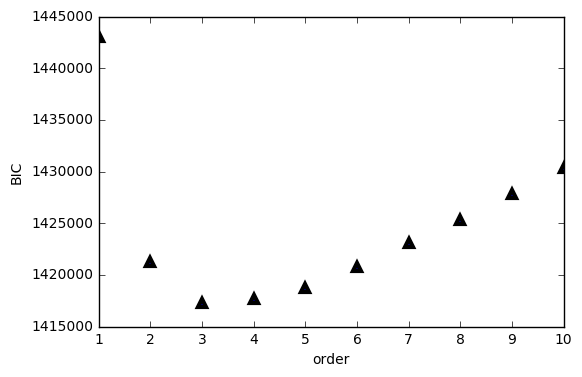

In [25]:
Y = np.array(dfr_f1).T
mu = np.mean(Y, axis=1)
X = Y - mu[:, None] #normalizing
#chosing model with BIC
p_max = 10 #maximum lag
p, bic = compute_order(X, p_max=p_max)

plt.figure()
plt.plot(np.arange(p_max + 1), bic,'b^', markeredgewidth = 3)
plt.xlabel('order')
plt.ylabel('BIC')
#plt.title("BIC model selection (19 channels eyes open)")
plt.savefig( "BIC_eyes_open(19)", bbox_inches='tight')
plt.show()

### 19 channels DFT

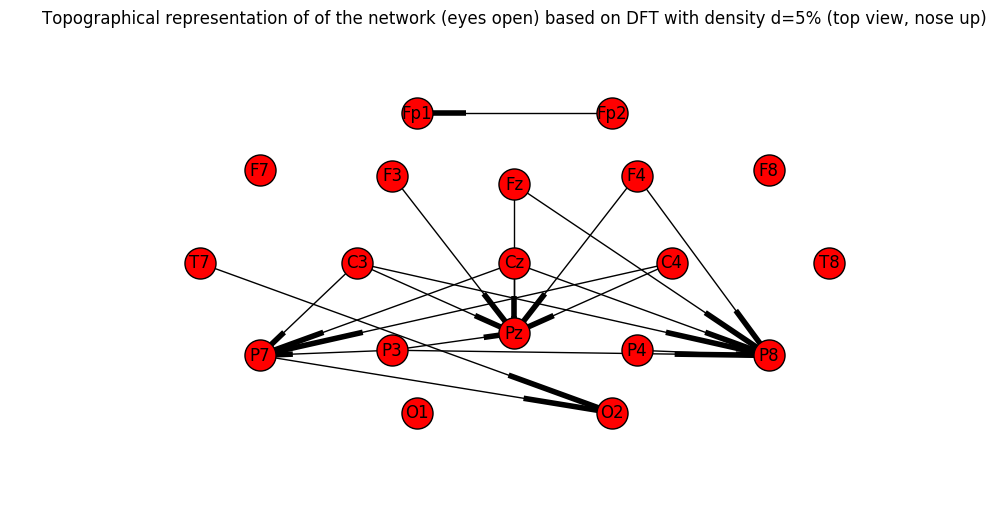

In [26]:
nodes = np.arange(len(list(dfr_f1.columns)))
labels = dict(zip(nodes, list(dfr_f1.columns)))
G_D_open_red=graph(dfr_f1,5,D = True)
atr = dict() #locations
for node in nodes:
    atr[node] = (locations.loc[labels[node]][1],locations.loc[labels[node]][2])

plt.figure(figsize=(12,6))
plt.title("Topographical representation of of the network (eyes open) based on DFT with density d=5% (top view, nose up)")
nx.draw(G_D_open_red, node_size=500, pos = atr,labels=labels, with_labels=True)
plt.savefig("topographical_DFT", bbox_inches='tight')
plt.show()

In [27]:
nx.density(G_D_open_red)

0.05847953216374269

### 19 channels Eyes open PDS 

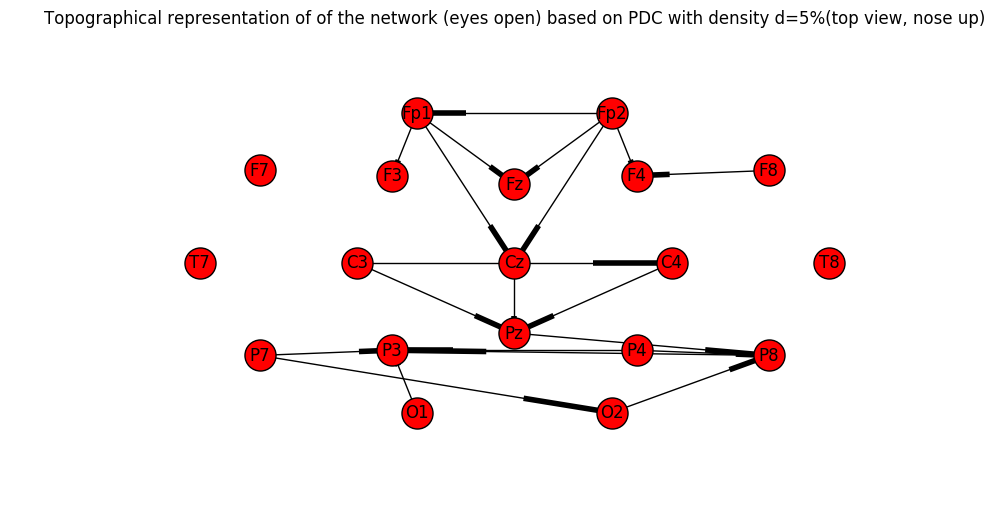

In [28]:
G_P_open_red=graph(dfr_f1,5,P = True)
plt.figure(figsize=(12,6))
plt.title("Topographical representation of of the network (eyes open) based on PDC with density d=5%(top view, nose up)")
nx.draw(G_P_open_red, node_size=500, pos = atr,labels=labels, with_labels=True)
plt.savefig("topographical_PDC", bbox_inches='tight')
plt.show()

In [29]:
nx.density(G_P_open_red)

0.05847953216374269

## 19 channels eyes closed:

1
2
3
4
5
6
7
8
9
10


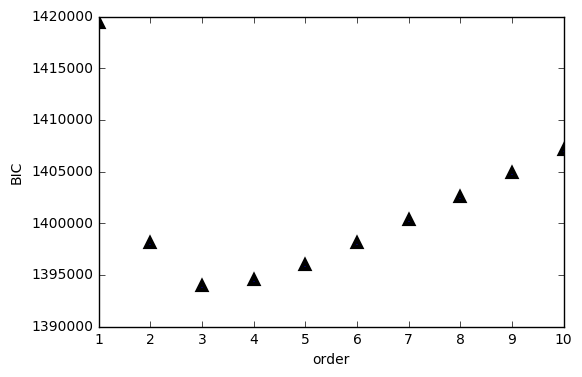

In [30]:
Y = np.array(dfr_f2).T
mu = np.mean(Y, axis=1)
X = Y - mu[:, None] #normalizing
#chosing model with BIC
p_max = 10 #maximum lag
p, bic = compute_order(X, p_max=p_max)

plt.figure()
plt.plot(np.arange(p_max + 1), bic,'b^', markeredgewidth = 3)
plt.xlabel('order')
plt.ylabel('BIC')
#plt.title("BIC model selection (19 channels eyes closed)")
plt.savefig( "BIC_eyes_closed(19)", bbox_inches='tight')
plt.show()

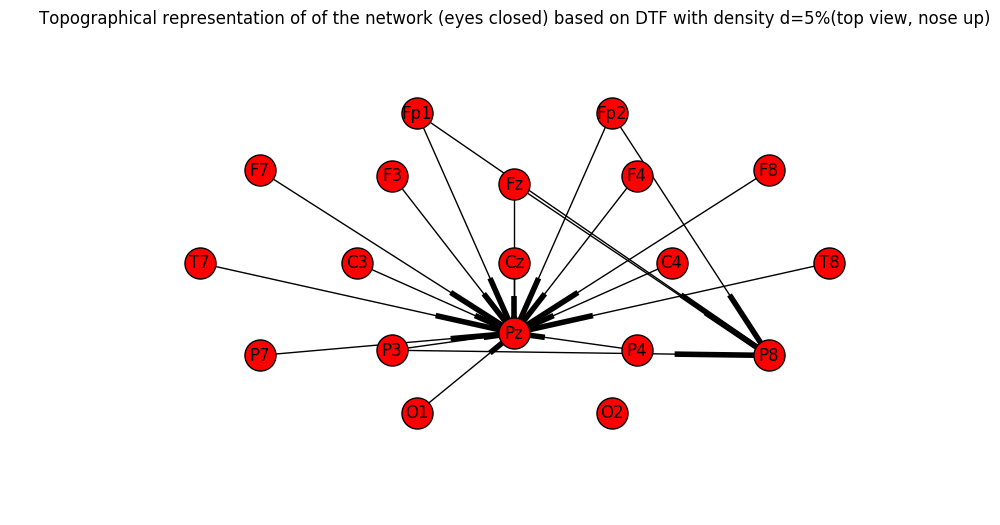

In [31]:
G_D_closed_red=graph(dfr_f2,5,D = True)
plt.figure(figsize=(12,6))
plt.title("Topographical representation of of the network (eyes closed) based on DTF with density d=5%(top view, nose up)")
nx.draw(G_D_closed_red, node_size=500, pos = atr,labels=labels, with_labels=True)
plt.savefig("topographical_DTF(closed)", bbox_inches='tight')
plt.show()

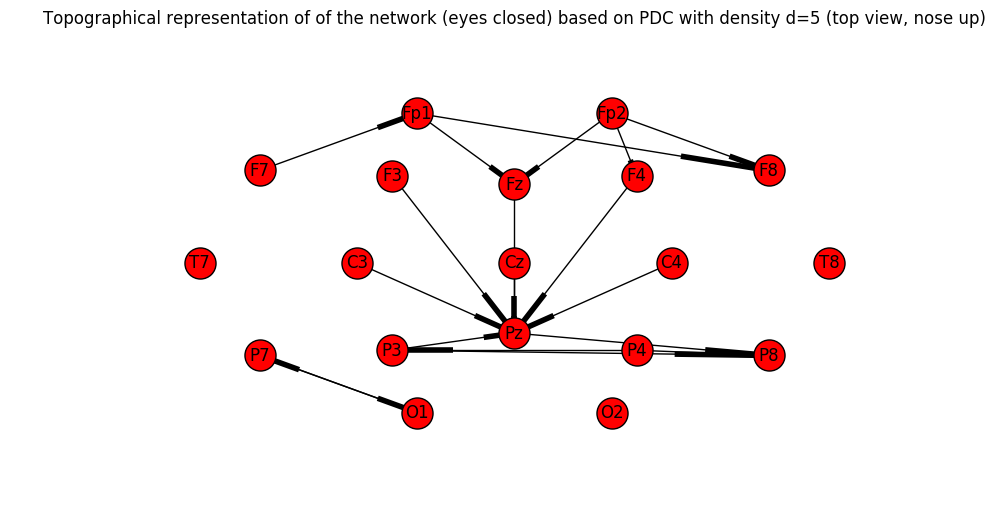

In [32]:
G_P_closed_red=graph(dfr_f2,5,P = True)
plt.figure(figsize=(12,6))
plt.title("Topographical representation of of the network (eyes closed) based on PDC with density d=5 (top view, nose up)")
nx.draw(G_P_closed_red, node_size=500, pos = atr,labels=labels, with_labels=True)
plt.savefig("topographical_PDC(closed)", bbox_inches='tight')
plt.show()

In [33]:
dfr_f1.to_csv(dir + "dfr_f1.csv")

For motif search:

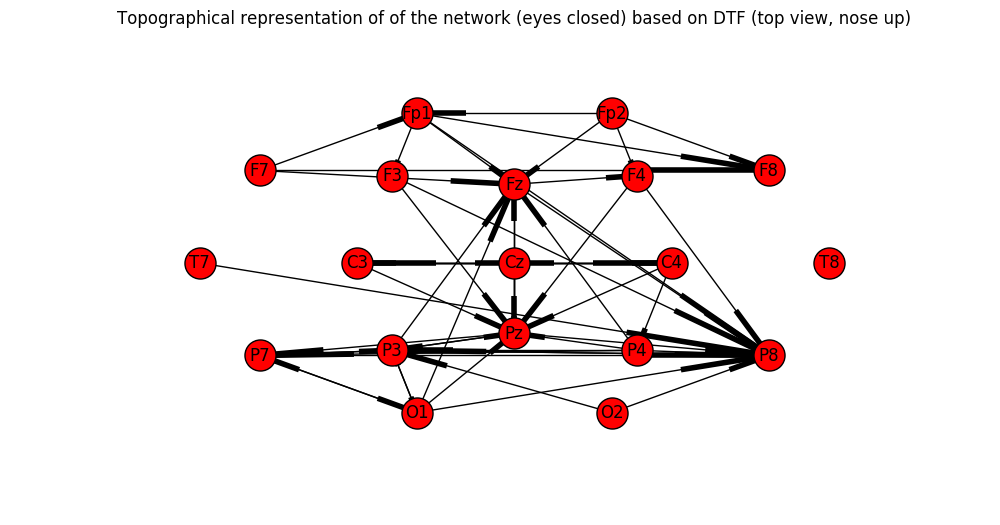

In [34]:
G_P_closed_dense=graph(dfr_f2,15,P = True)
plt.figure(figsize=(12,6))
plt.title("Topographical representation of of the network (eyes closed) based on DTF (top view, nose up)")
nx.draw(G_P_closed_dense, node_size=500, pos = atr,labels=labels, with_labels=True)
plt.show()

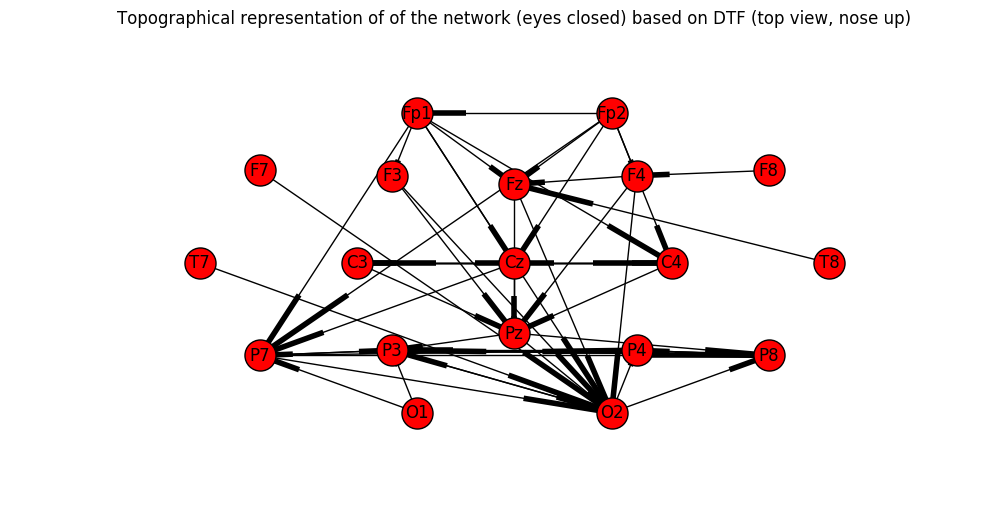

In [35]:
G_P_open_dense=graph(dfr_f1,15,P = True)
plt.figure(figsize=(12,6))
plt.title("Topographical representation of of the network (eyes closed) based on DTF (top view, nose up)")
nx.draw(G_P_open_dense, node_size=500, pos = atr,labels=labels, with_labels=True)
plt.show()

In [36]:
nx.write_weighted_edgelist(G_P_closed_dense, path=dir + "for_motifs_c.nx")
nx.write_weighted_edgelist(G_P_open_dense, path=dir + "for_motifs_o.nx")

### 2.6 O:

In [39]:
locations_all = pd.read_csv("channel_locations.csv", sep = "\s+") 
locations_all["label"] = locations_all["label"].apply(lambda x:re.sub('[^\w]',"",x))
locations_all = locations_all.set_index('label')

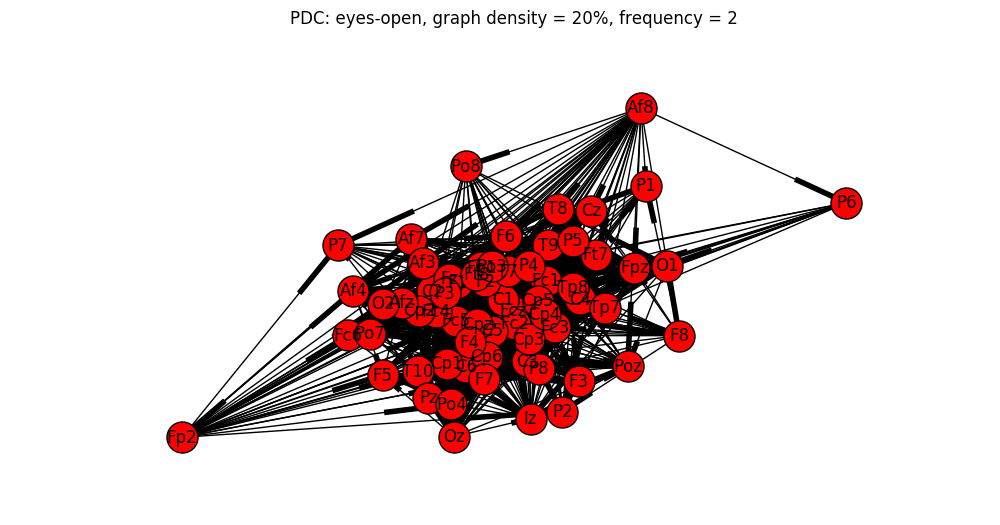

In [50]:
Y = np.array(df_f1).T
mu = np.mean(Y, axis=1)
X = Y - mu[:, None] #normalizing
p =2
nodes = np.arange(len(list(df_f1.columns)))
atr = dict() #locations
for node in nodes:
    atr[node] = (locations_all.loc[labels[node]][1],locations_all.loc[labels[node]][2])
labels = dict(zip(nodes, list(df_f1.columns)))
G_P_open_f=graph(df_f1,20,P = True,freq = 2)
plt.figure(figsize=(12,6))
plt.title("PDC: eyes-open, graph density = 20%, frequency = 2")
nx.draw(G_P_open_f, node_size=500, labels=labels, with_labels=True)
plt.savefig("PDC_eyes_open_f2", bbox_inches='tight')
plt.show()


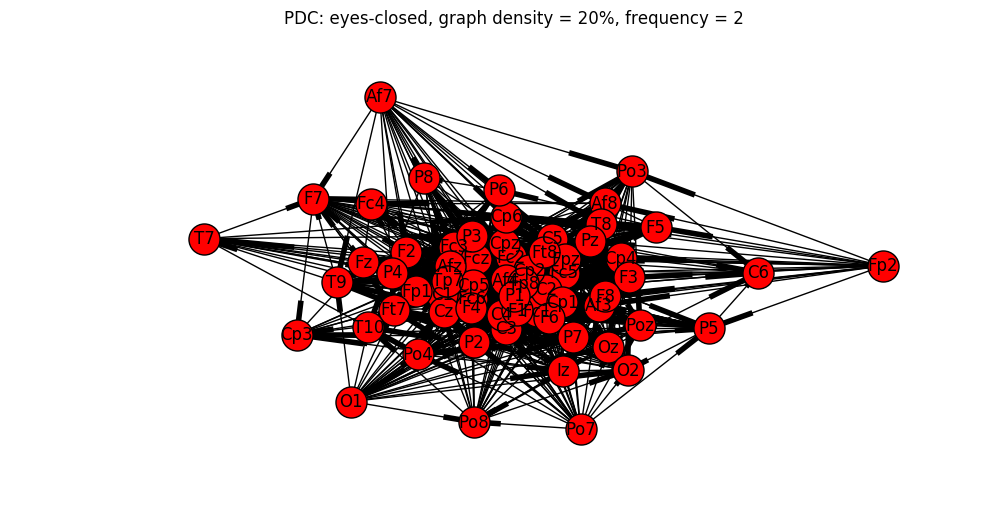

In [51]:
G_P_close_f=graph(df_f2,20,P = True,freq = 2)
plt.figure(figsize=(12,6))
plt.title("PDC: eyes-closed, graph density = 20%, frequency = 2")
nx.draw(G_P_close_f, node_size=500, labels=labels, with_labels=True)
plt.savefig("PDC_eyes_closed_f2", bbox_inches='tight')
plt.show()

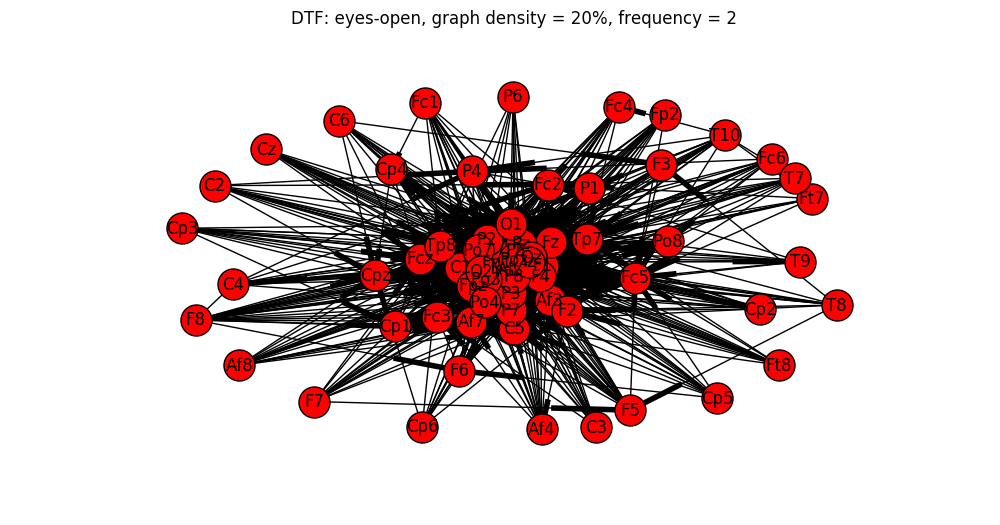

In [54]:
G_D_open_f=graph(df_f1,20,D = True,freq = 2)
plt.figure(figsize=(12,6))
plt.title("DTF: eyes-open, graph density = 20%, frequency = 2")
nx.draw(G_D_open_f, node_size=500, labels=labels, with_labels=True)
plt.savefig("DTF_eyes_open_f2", bbox_inches='tight')
plt.show()

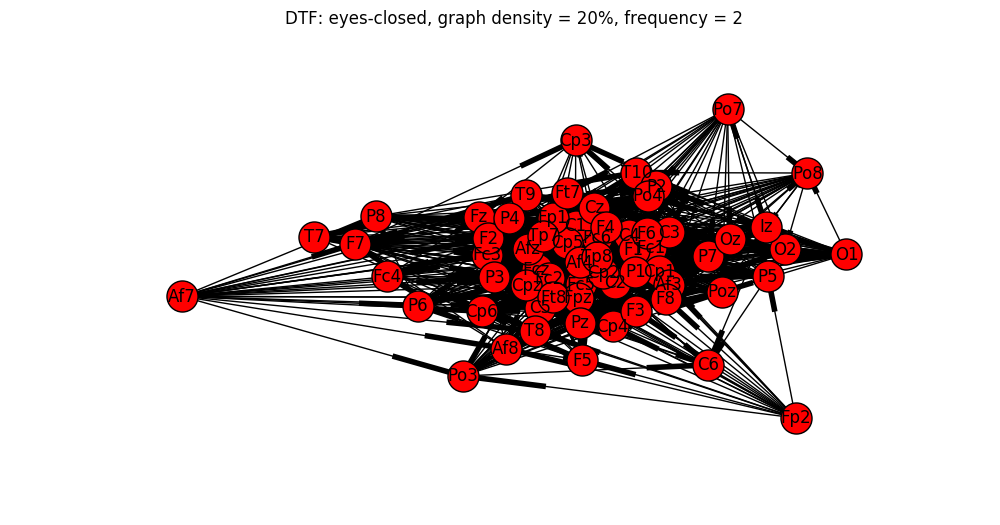

In [55]:
G_D_close_f=graph(df_f2,20,P = True,freq = 2)
plt.figure(figsize=(12,6))
plt.title("DTF: eyes-closed, graph density = 20%, frequency = 2")
nx.draw(G_D_close_f, node_size=500, labels=labels, with_labels=True)
plt.savefig("DTF_eyes_closed_f2", bbox_inches='tight')
plt.show()

Weighted graphs for 3.7:

### different density:

In [76]:
density = [1,5,10,20,30,40]
graphs = []
for d in density:
    graphs.append(graph(df_f1,d,D = True))
    

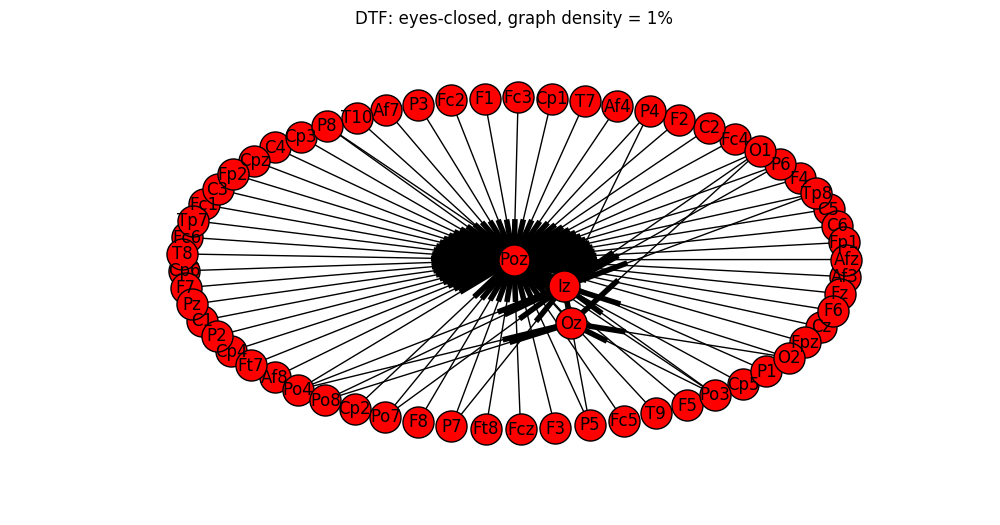

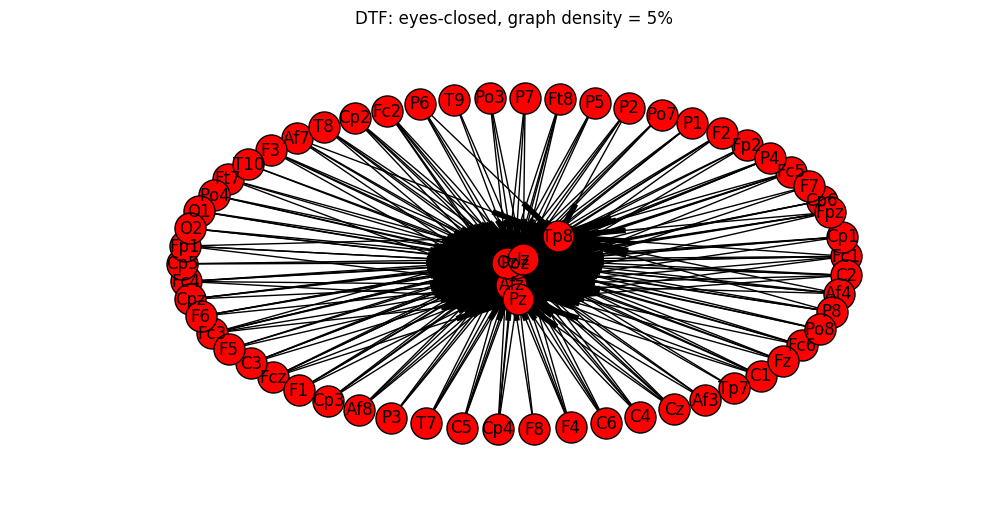

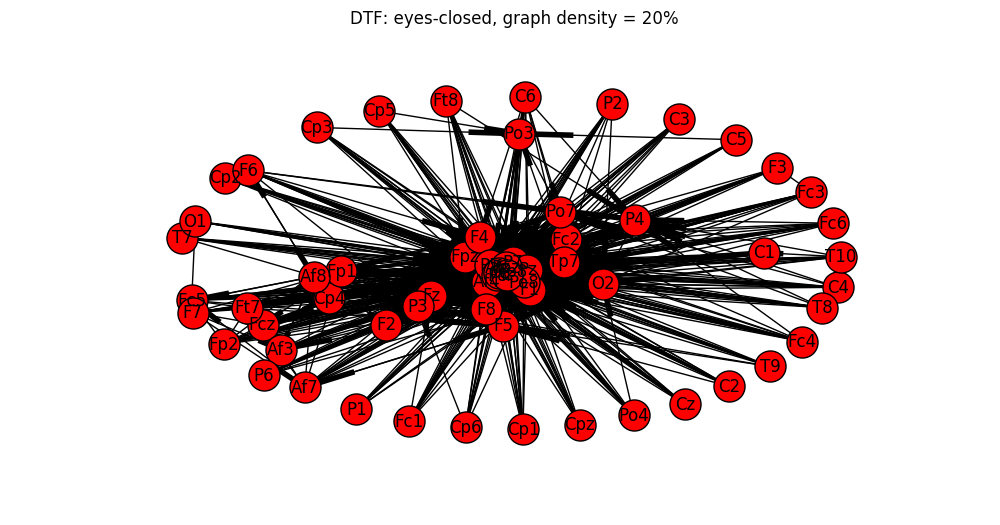

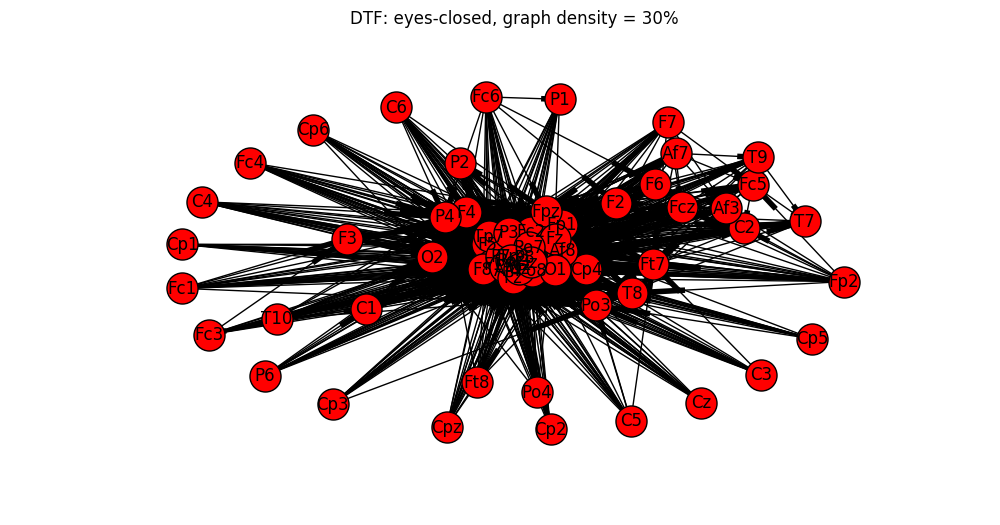

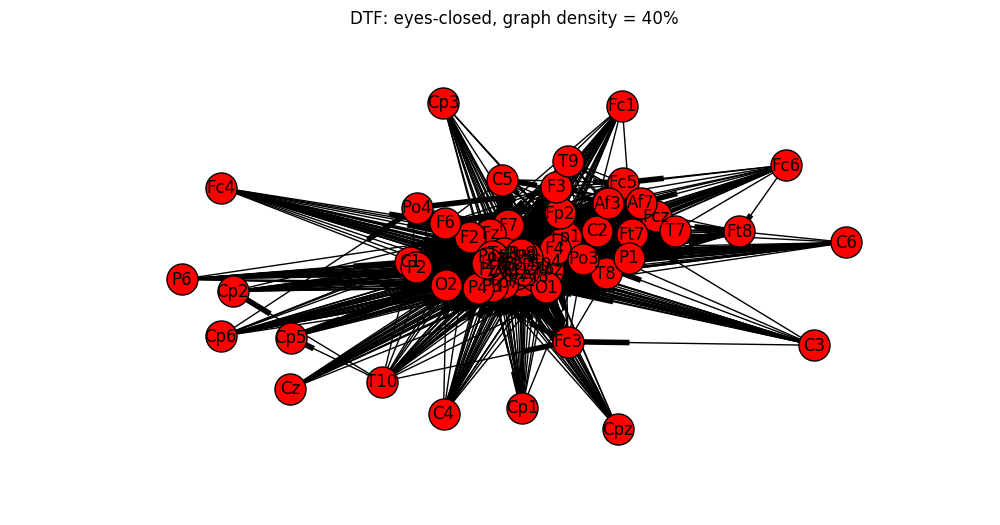

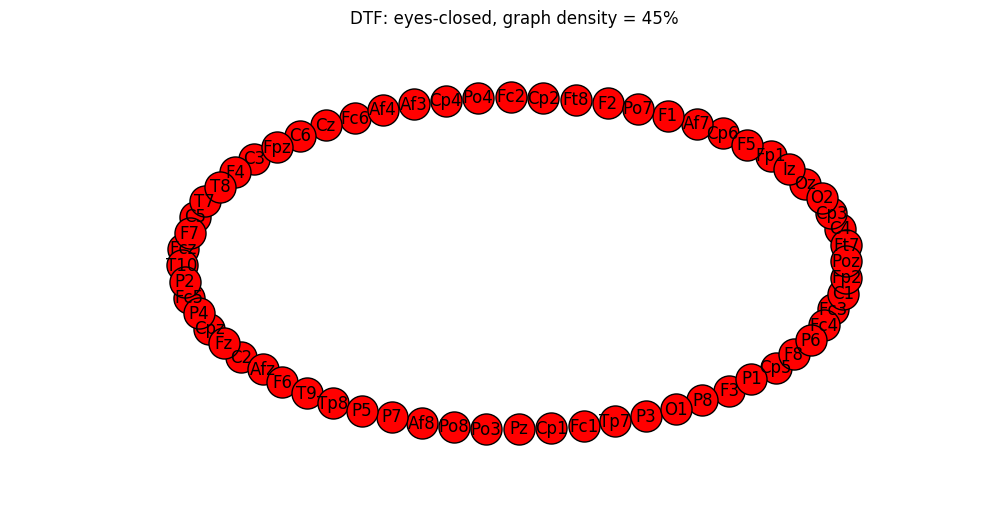

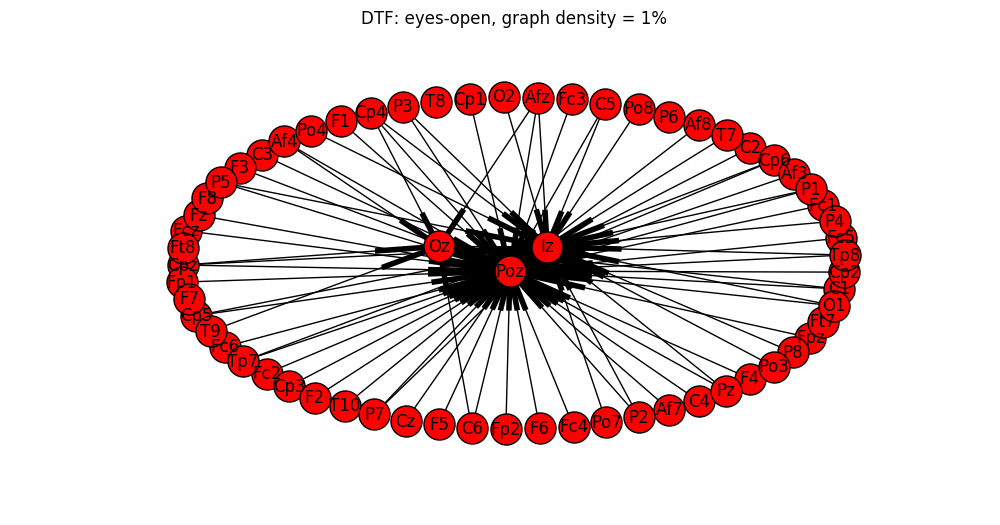

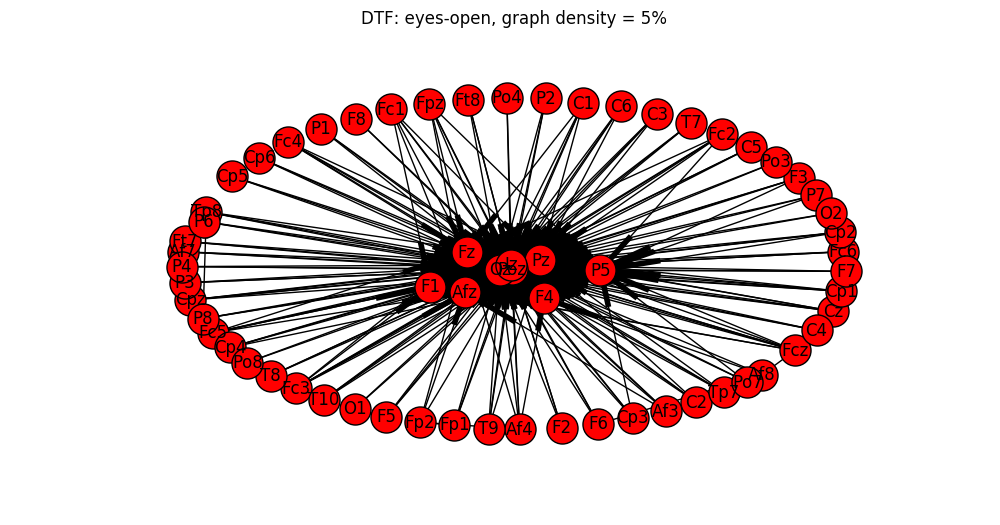

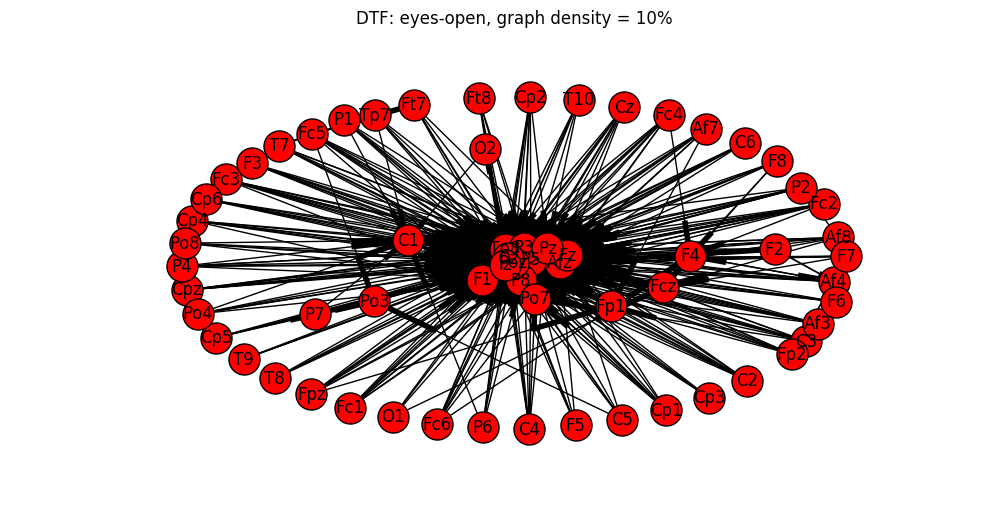

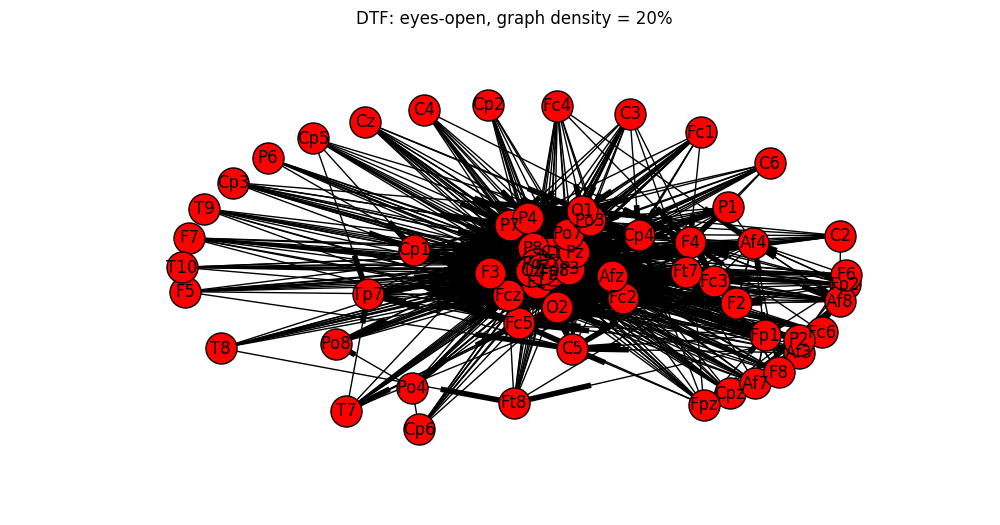

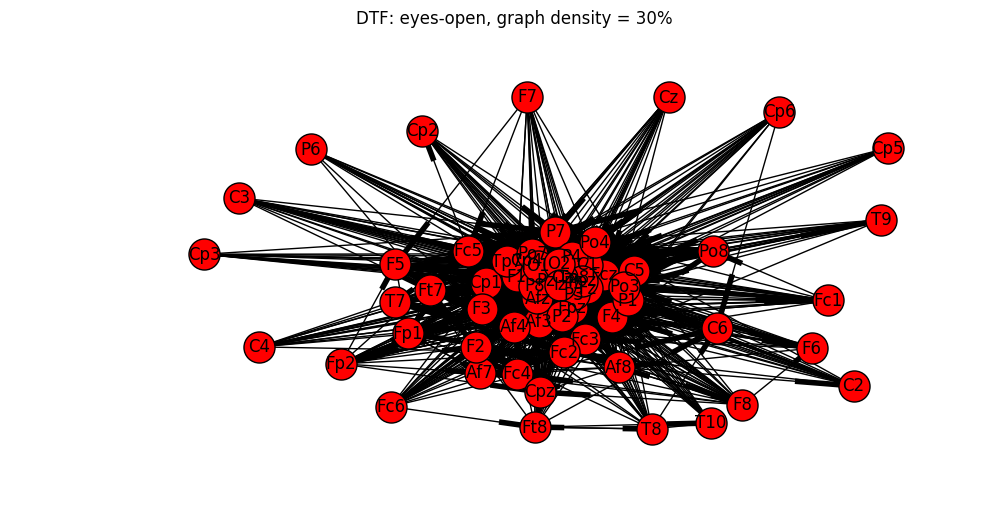

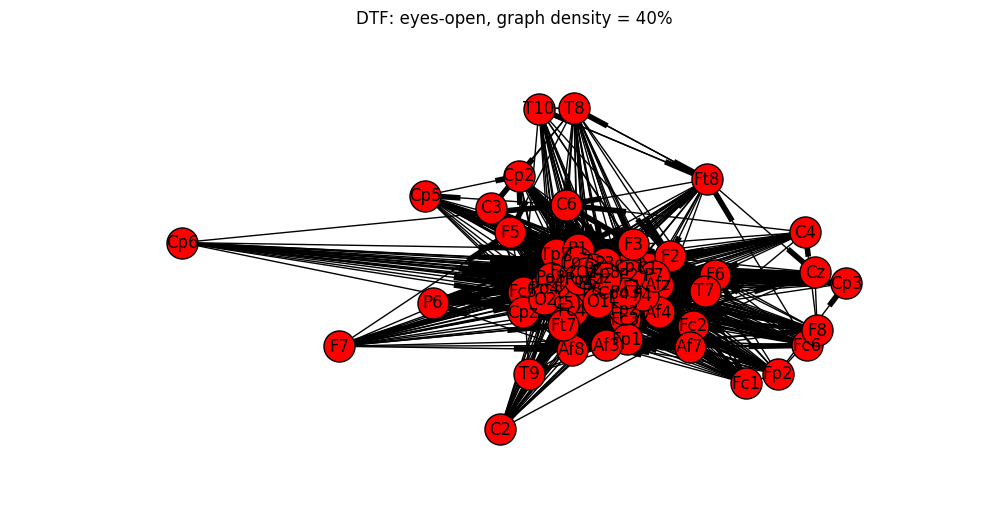

In [77]:
i = 0
for g in graphs:
    plt.figure(figsize=(12,6))
    plt.title("DTF: eyes-open, graph density = "+str(density[i])+ "%")
    nx.draw(g, node_size=500, labels=labels, with_labels=True)
    plt.savefig("DTF_dif_dens_o"+str(density[i]), bbox_inches='tight')
    i = i+1
plt.show()
    

In [79]:
graphs = []
for d in density:
    graphs.append(graph(df_f2,d,D = True))
i = 0
for g in graphs:
    plt.figure(figsize=(12,6))
    plt.title("DTF: eyes-closed, graph density = "+str(density[i])+ "%")
    nx.draw(g, node_size=500, labels=labels, with_labels=True)
    plt.savefig("DTF_dif_dens_c"+str(density[i]), bbox_inches='tight')
    i = i+1